In [1]:
from pathlib import Path
import numpy as np
import pydicom
import matplotlib.pyplot as plt
phantom_dir = Path('/gpfs_projects/brandon.nelson/REALYSM_peds/test_torsos/output_images_2023-08-09/phantoms')

In [2]:
phantom_names = list(phantom_dir.glob('*'))
phantom_names

[PosixPath('/gpfs_projects/brandon.nelson/REALYSM_peds/test_torsos/output_images_2023-08-09/phantoms/female_pt152'),
 PosixPath('/gpfs_projects/brandon.nelson/REALYSM_peds/test_torsos/output_images_2023-08-09/phantoms/male_pt321'),
 PosixPath('/gpfs_projects/brandon.nelson/REALYSM_peds/test_torsos/output_images_2023-08-09/phantoms/male_pt324'),
 PosixPath('/gpfs_projects/brandon.nelson/REALYSM_peds/test_torsos/output_images_2023-08-09/phantoms/male_pt96'),
 PosixPath('/gpfs_projects/brandon.nelson/REALYSM_peds/test_torsos/output_images_2023-08-09/phantoms/male_infant_ref'),
 PosixPath('/gpfs_projects/brandon.nelson/REALYSM_peds/test_torsos/output_images_2023-08-09/phantoms/female_pt151')]

In [47]:
phantom_path = phantom_names[-1]
dcms = list(phantom_path.glob('*.dcm'))
dicom_filename = dcms[0]
dicom_filename

PosixPath('/gpfs_projects/brandon.nelson/REALYSM_peds/test_torsos/output_images_2023-08-09/phantoms/female_pt151/ground_truth_141.dcm')

In [48]:
slice_id = dicom_filename.stem.split('_')[-1]
slice_id

'141'

## TODO: get liver orgagn masks for each slice and have option to iesion into each, this will be another opti when runingRunender

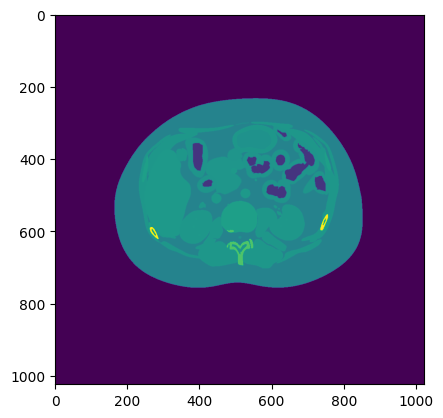

In [49]:
dcm_file = pydicom.read_file(dcms[0])
img = dcm_file.pixel_array
plt.imshow(img)

In [50]:
def load_dicom_image(dicom_filename): return pydicom.read_file(dicom_filename).pixel_array

In [51]:
img = load_dicom_image(dicom_filename)
img.shape

(1024, 1024)

In [52]:
def load_volume(path, shape=(501, 1024, 1024), dtype='float32'):
  input_image = np.fromfile(path, dtype=dtype)
  input_image = input_image.reshape(shape)
  return(input_image)

In [53]:
phantom_path

PosixPath('/gpfs_projects/brandon.nelson/REALYSM_peds/test_torsos/output_images_2023-08-09/phantoms/female_pt151')

In [54]:
slice_id

'141'

In [55]:
organs = ['adipose', 'liver', 'lung', 'bone', 'water']

masks = list((phantom_path / f'voxelized_{slice_id}').glob(f'*liver*x1.raw'))
masks

[PosixPath('/gpfs_projects/brandon.nelson/REALYSM_peds/test_torsos/output_images_2023-08-09/phantoms/female_pt151/voxelized_141/voxelized_141_ICRU_liver_adult_1024x1024x1.raw')]

In [31]:
mask = load_volume(masks[0], shape=(1024,1024))
mask.shape

(1024, 1024)

In [56]:
def load_organ_mask(phantom_path, slice_id, organ='liver'):
    mask_filename = list((phantom_path / f'voxelized_{slice_id}').glob(f'*{organ}*x1.raw'))[0]
    mask = load_volume(mask_filename, shape=(1024,1024))
    if organ == 'liver':
        mask = mask == 1.049
    return mask

In [35]:
np.unique(mask)

array([0.   , 1.001, 1.017, 1.025, 1.039, 1.049, 1.053], dtype=float32)

In [57]:
liver_mask = load_organ_mask(phantom_path, slice_id)
liver_mask.shape

(1024, 1024)

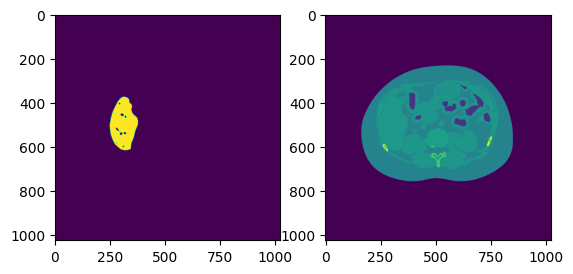

In [58]:
f, axs = plt.subplots(1,2)
axs[0].imshow(liver_mask)
axs[1].imshow(img)
# plt.colorbar()

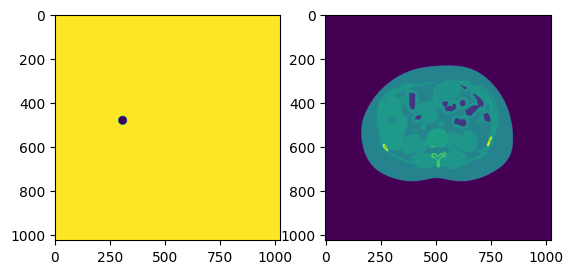

In [59]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table


def add_random_circle_lesion(image, mask, radius=20, contrast=-100):
    r = radius
    area = (np.pi*r**2)*0.95
    lesion_image = np.zeros_like(image)
    counts = 0
    while np.sum(mask & (lesion_image==contrast)) < area: #can increase threshold to size of lesion
        counts += 1
        lesion_image = np.zeros_like(image)

        x, y = np.argwhere(mask)[np.random.randint(0, mask.sum())]

        rr, cc = ellipse(x, y, r, r)
        lesion_image[rr, cc] = contrast #in HU
        if counts > 10:
            raise ValueError("Failed to insert lesion into mask")

    img_w_lesion = image + lesion_image
    return img_w_lesion, lesion_image, (x, y)

img_w_lesion, lesion_image, _ = add_random_circle_lesion(img, liver_mask)

f, axs = plt.subplots(1,2)
axs[0].imshow(lesion_image)
axs[1].imshow(img_w_lesion)